Vista previa del dataset:
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  
0 2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3 2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4 2009-12-01 07:45:00   1.25      13085.0  United Kingdom  

Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         

<ipython-input-4-1c4e59364f87>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])



Valores nulos tras limpieza:
Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

Tipos de datos tras conversión:
Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object

Ejemplo de granularidad por cliente y fecha:
   Customer ID         InvoiceDate  Cantidad de Transacciones
0      12346.0 2009-12-14 08:34:00                          1
1      12346.0 2009-12-14 11:00:00                          1
2      12346.0 2009-12-14 11:02:00                          1
3      12346.0 2009-12-18 10:47:00                          1
4      12346.0 2009-12-18 10:55:00                          1


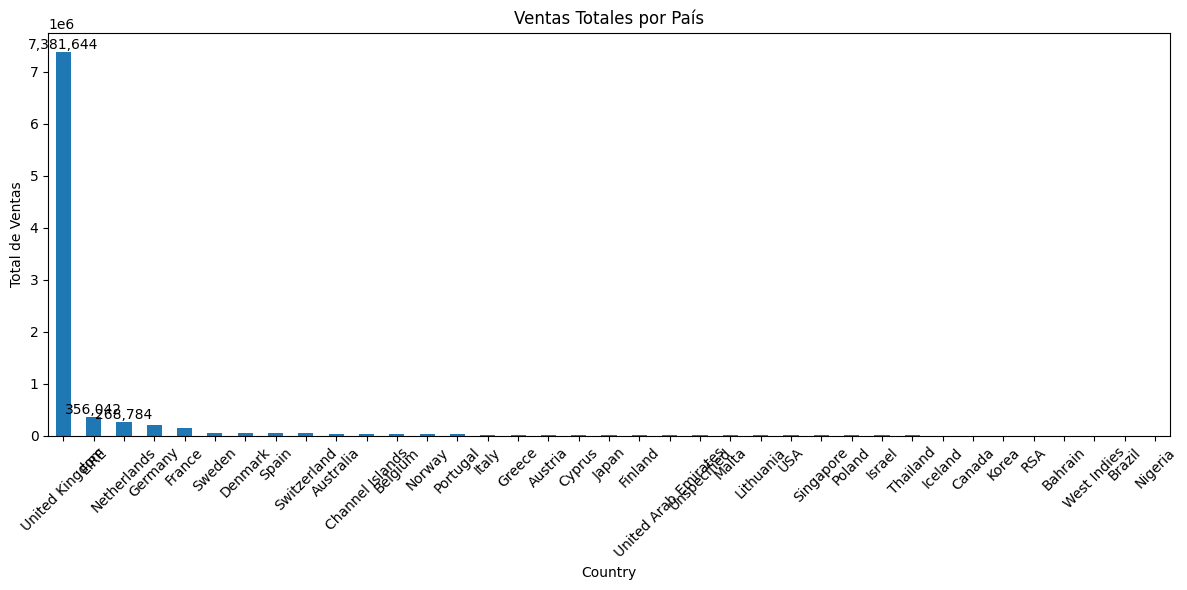

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# === 1. Carga de Datos ===
df = pd.read_excel('/content/sample_data/online_retail_II.xlsx')

# === 2. Perfilado Inicial de Datos ===
print("Vista previa del dataset:")
print(df.head())

print("\nInformación general del dataset:")
print(df.info())

print("\nValores nulos por columna:")
print(df.isnull().sum())

print("\nEstadísticas descriptivas:")
print(df.describe(include='all'))

print("\nDistribución de registros por país:")
print(df['Country'].value_counts())

print("\nMatriz de correlaciones:")
print(df.corr(numeric_only=True))

print("\nCantidad de filas duplicadas:")
print(df.duplicated().sum())

# === 3. Tabla Resumen de Problemas Detectados ===
problemas_detectados = pd.DataFrame({
    'Variable': ['Customer ID', 'Description', 'Quantity', 'UnitPrice', 'Duplicados', 'Country'],
    'Tipo de problema': ['Nulos', 'Nulos/Calidad texto', 'Valores inválidos', 'Negativos/Ceros', 'Duplicación', 'Sesgo geográfico'],
    'Justificación': [
        'Imposible hacer análisis RFM sin identificar cliente',
        'Afecta la calidad semántica del producto',
        'No se pueden considerar compras con cantidad <= 0',
        'Precios negativos pueden ser devoluciones o errores',
        'Duplicados distorsionan totales y frecuencias',
        'Más del 90% del dataset viene de UK, puede afectar comparabilidad'
    ]
})
print("\nResumen de problemas detectados:")
print(problemas_detectados)

# === 4. Limpieza de Datos ===

# Eliminar duplicados
df = df.drop_duplicates()

# Filtrar registros con valores válidos
df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]

# Eliminar registros sin Customer ID
df = df.dropna(subset=['Customer ID'])

# Convertir fechas
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Eliminar espacios innecesarios y estandarizar mayúsculas en descripción
df['Description'] = df['Description'].str.strip().str.upper()

# === 5. Validaciones Post-Limpieza ===

# Comprobación de nulos restantes
print("\nValores nulos tras limpieza:")
print(df.isnull().sum())

# Verificar tipo de datos
print("\nTipos de datos tras conversión:")
print(df.dtypes)

# Verificar granularidad mínima por cliente y fecha
granularidad = df.groupby(['Customer ID', 'InvoiceDate']).size().reset_index(name='Cantidad de Transacciones')
print("\nEjemplo de granularidad por cliente y fecha:")
print(granularidad.head())

# === Guardar Datos Limpios ===
df.to_excel('/content/sample_data/online_retail_II_limpio.xlsx', index=False)

# === 6. Visualización: Ventas Totales por País ===

# Crear columna de ingreso total correcto
df['TotalSales'] = df['Quantity'] * df['Price']

# Agrupar por país
ventas_por_pais = df.groupby('Country')['TotalSales'].sum().sort_values(ascending=False)

# Graficar
plt.figure(figsize=(12, 6))
ventas_por_pais.plot(kind='bar')
plt.title('Ventas Totales por País')
plt.ylabel('Total de Ventas')
plt.xticks(rotation=45)

# Anotar Top 3
top3 = ventas_por_pais.head(3)
for i, (pais, valor) in enumerate(top3.items()):
    plt.text(i, valor, f'{valor:,.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()
